# Autoencoder-for-HDFS-Log-Anomaly-Detection

HDFS Log 데이터를 이용하여 Autoencoder Anomaly Detection 진행.

---

In [23]:
# import section
from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import  Model
from keras.layers import Dense, Input

import pandas as pd
import os
import numpy as np
import re
from sklearn.utils import shuffle
from collections import OrderedDict

from utils import dataloader
from utils import preprocessing

In [24]:
# 그래픽 카드 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1249103612968565817
]


In [25]:
struct_log = './data/HDFS_100k.log_structured.csv' # The structured log file
label_file = './data/HDFS_100k.log_anomaly_label.csv' # The anomaly label file

In [26]:
df = pd.read_csv(struct_log)

In [27]:
# simple EDA
for i in df.columns:
    print(i)
    print(df[i].unique())
    print(len(df[i].unique()))
    print(' === ')

LineId
[     1      2      3 ... 104813 104814 104815]
104815
 === 
Date
[81109]
1
 === 
Time
[203518 203519 203520 ... 210122 210124 210126]
1406
 === 
Pid
[143  35 145 147  29  30  31 142  26 144 146 148  19  27  33  34 149  28
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193  32 194 195 196 197 198 199 201 202 203
 204 205 206 207 208 209 210 211 200 212 213 214 215 217 218 216 219 220
 221 223 224 226 222 227 228 225 229 231 232 233 235 234 237 238  13 249
 241 251 230 250 255 258 245 252 254 260 259 256 263 266 262 272 273 239
 275 269 271 278 281 253 283 261 242 287 289 243 246 277 240 293 236 247
 295 244 288 297 248 264 292 274 294 257 296 267 270 299 303 285 304 306
 284 276 308 312 313 311 279 282 314 298 268 323 324 290 265 309 310 327
 280 330 305 300 333 334 316 335 286 338 315 328 291 325 322 302 326 341
 344 329 347 343 307 301 355 336 352 358

In [28]:
from utils import dataloader
from utils.preprocessing import Vectorizer


batch_size = 32
hidden_size = 32
num_directions = 2
topk = 5
train_ratio = 0.2
window_size = 10
epoches = 2
num_workers = 2
device = 0 

(x_train, window_y_train, y_train), (x_test, window_y_test, y_test) = \
dataloader.load_HDFS(struct_log, label_file=label_file, window='session',                                                                                                          window_size=window_size, train_ratio=train_ratio, split_type='uniform')


====== Input data summary ======
Loading ./data/HDFS_100k.log_structured.csv
62 251
Slicing 1587 sessions, with window 10
Slicing done, 8406 windows generated
Slicing 6353 sessions, with window 10
Slicing done, 25807 windows generated
Train: 8406 windows (464/8406 anomaly), 7942/8406 normal
Test: 25807 windows (842/25807 anomaly), 24965/25807 normal


In [29]:
feature_extractor = Vectorizer()
train_dataset = feature_extractor.fit_transform(x_train, window_y_train, y_train)
test_dataset = feature_extractor.transform(x_test, window_y_test, y_test)

In [30]:
train_dataset

{'SessionId': array([   0,    0,    0, ..., 1586, 1586, 1586]),
 'window_y': array([2, 3, 4, ..., 4, 4, 1]),
 'y': array([0, 0, 0, ..., 0, 0, 0]),
 'x': array([[8, 0, 8, ..., 3, 4, 4],
        [0, 8, 8, ..., 4, 4, 2],
        [8, 8, 2, ..., 4, 2, 3],
        ...,
        [0, 8, 8, ..., 2, 3, 4],
        [8, 8, 2, ..., 3, 4, 4],
        [8, 2, 3, ..., 4, 4, 4]])}

In [31]:
train_dataset['x'] = train_dataset['x']/12

In [32]:
test_dataset['x'] = test_dataset['x']/12

In [33]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='./data/log_model_HDFS.h5',
    monitor='val_loss',
    save_best_only=True
    )
]

In [34]:
# Create 6 layer model.
input_dim = train_dataset['x'].shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(input_dim//4*3, activation='relu')(input)
encode = Dense(input_dim//4*2, activation='relu')(encode)
encode = Dense(input_dim//4, activation='relu')(encode)
encode = Dense(1, activation='relu')(encode)

decode = Dense(input_dim//4, activation='relu')(encode)
decode = Dense(input_dim//4*2, activation='relu')(decode)
decode = Dense(input_dim//4*3, activation='relu')(decode)
decode = Dense(input_dim, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])

# Train model.
history = autoencoder.fit(train_dataset['x'], train_dataset['x'],
        epochs=50,
        batch_size=32,
        callbacks=callbacks_list,
        validation_data=(test_dataset['x'], test_dataset['x']),
        shuffle=True
        )

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 6)                 66        
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 3         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 12  

In [35]:
np.int64(autoencoder.predict(train_dataset['x'])*12)

array([[5, 4, 4, ..., 3, 3, 4],
       [5, 4, 4, ..., 3, 3, 4],
       [5, 4, 4, ..., 3, 3, 4],
       ...,
       [5, 4, 4, ..., 3, 3, 4],
       [5, 4, 4, ..., 3, 3, 4],
       [5, 4, 4, ..., 3, 3, 4]])

In [36]:
# # Create 3 layer model.
# input_dim = train_dataset['x'].shape[1]
# input = Input(shape=(input_dim, ))
# encode = Dense(input_dim//2, activation='relu')(input)
# encode = Dense(1, activation='relu')(encode)

# decode = Dense(input_dim//2, activation='relu')(encode)
# decode = Dense(input_dim, activation='sigmoid')(decode)

# autoencoder = Model(input, decode)

# autoencoder.summary()

# autoencoder.compile(optimizer='adam',
#             loss='mean_squared_error',
#             metrics=['accuracy'])

# # Train model.
# history = autoencoder.fit(train_dataset['x'], train_dataset['x'],
#         epochs=50,
#         batch_size=32,
#         callbacks=callbacks_list,
#         validation_data=(test_dataset['x'], test_dataset['x']),
#         shuffle=True
#         )

In [37]:
new_x=test_dataset['x']

predictions = autoencoder.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# Set threshold at the 99th quartile.
threshold = error_df.quantile(0.99)

error_df.describe()

,reconstruction_error
count,25807.000000
mean,0.030508
std,0.018504
min,0.007205
25%,0.016171
50%,0.027061
75%,0.045149
max,0.135201


In [38]:
error_df.quantile(0.99)

reconstruction_error    0.067078
Name: 0.99, dtype: float64

(array([12437.,  6765.,  6286.,   216.,    46.,    39.,    18.]),
 array([0.00720522, 0.02549038, 0.04377553, 0.06206068, 0.08034584,
        0.09863099, 0.11691615, 0.1352013 ]),
 <BarContainer object of 7 artists>)

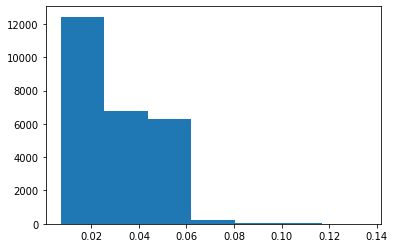

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

# Reconstruction error binned and plotted.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(error_df.reconstruction_error.values, bins=7)

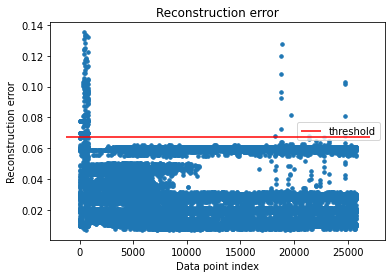

In [40]:
threshold = threshold

# Plot reconstruction error vs. the data.
fig, ax = plt.subplots()
ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='threshold')
ax.legend(loc=5)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [41]:
# Output anomalies.
index_list = []
for index, row in error_df.iterrows():
    if row.reconstruction_error > int(threshold):
        index_list.append(index)

In [42]:
result = test_dataset['y'][index_list]

In [43]:
_, (false_value,true_value) = np.unique(result,return_counts=True)

In [44]:
print(len(result) ,false_value, true_value)

25807 24965 842


In [45]:
true_value / len(result)

0.03262680668035804

In [46]:
true_value

842

* 참조 링크  
1. Autoencoder : https://github.com/zpettry/AI-Autoencoder-for-HTTP-Log-Anomaly-Detection
2. Data & preprocess : https://github.com/logpai/loglizer 